In [96]:
import numpy as np 
import pandas as pd
import sklearn.datasets
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
import math
import graphviz
from copy import deepcopy
from tqdm import tqdm_notebook

In [97]:
data = pd.read_csv('bupa.csv')
data['drinks'] = (data['drinks'] > 5).astype(int)

In [98]:
data

,mcv,alkphos,sgpt,sgot,gammagt,drinks
0,85,92,45,27,31,0
1,85,64,59,32,23,0
2,86,54,33,16,54,0
3,91,78,34,24,36,0
4,87,70,12,28,10,0
...,...,...,...,...,...,...
336,99,75,26,24,41,1
337,96,69,53,43,203,1
338,98,77,55,35,89,1
339,91,68,27,26,14,1


In [99]:
X = data.drop('drinks',axis = 1)
Y = data['drinks']

In [100]:
X_TRAIN = []
Y_TRAIN = []
X_TEST = []
Y_TEST = []
for i in range(10):
  X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size = 0.2,stratify = Y)
  X_TRAIN.append(X_train)
  Y_TRAIN.append(Y_train)
  X_TEST.append(X_test)
  Y_TEST.append(Y_test)

In [101]:
class Node:
   def __init__(self, val, name = "", gini = None, gain = None, res = None ):
      self.left = None
      self.right = None
      self.data = val
      self.name = name 
      self.gini = gini 
      self.gain = gain
      self.res = res

In [102]:
class DTCla:

  def __init__(self):
    self.Tree = None
  
  def entropy(self, x, y):
    p0 = 0
    p1 = 0
    for y1 in y:
      if y1 == 1:
        p1 += 1
      else:
        p0 += 1
    p0 = p0/len(y)*1.0
    p1 = p1/len(y)*1.0
    e = -1.0*p1*math.log2(p1)-1.0*p2*math.log(p2)
    return e
  
  def InfoGain(self, x_train, y_train):
    ones = 0
    zeros = 0
    for y in y_train:
      if y == 1:
        ones += 1
      else:
        zeros += 1
    if ones == 0 or zeros == 0:
      return [None,1.0,None]
    names = list(x_train.columns)
    XX = []
    YY = []
    Z = 0
    O = 0
    for yt in y_train:
      if yt == 1:
        O += 1
      else:
        Z += 1
    Z = 1.0*Z/len(y_train)
    O = 1.0*O/len(y_train)
    if Z == 0 or O == 0:
      E_S = 0
    else:
      E_S = -Z*math.log2(Z)-O*math.log2(O)
    for c in names:
      X = []
      Y = []
      x = x_train
      x = x.join(y_train)
      ma = int(x[c].max())
      mi = int(x[c].min())
      arr = np.linspace(mi,ma,100).tolist()
      for i in arr:
        g = 0
        L = x[x[c] <= i]
        R = x[x[c] > i]
        L1 = 0
        L2 = 0
        R1 = 0
        R2 = 0
        for l in L['drinks']:
          if l == 0:
            L1 += 1
          else:
            L2 += 1
        for r in R['drinks']:
          if r == 0:
            R1 += 1
          else:
            R2 += 1
        if L1+L2 == 0 or R1+R2 == 0:
          continue
        Pl1 = L1/(L1+L2)*1.0
        Pl2 = L2/(L1+L2)*1.0
        PR1 = R1/(R1+R2)*1.0
        PR2 = R2/(R1+R2)*1.0

        if Pl1 == 0 or Pl2 == 0:
          El = 0
        else:
          El = (-1.0*Pl1*(math.log2(Pl1)))+(-1.0*Pl2*(math.log2(Pl2)))
        if PR1 == 0 or PR2 == 0:
          Er = 0
        else:
          Er = (-1.0*PR1*(math.log2(PR1)))+(-1.0*PR2*(math.log2(PR2)))
        
        El *= 1.0*(L1+L2)/341

        Er *= 1.0*(R1+R2)/341

        G = E_S - El - Er
        X.append(i)
        Y.append(G)
      XX.append(X)
      YY.append(Y)
    maxi = [] 
    gini = []
    # print(len(y_train),YY)
    for i in range(len(names)):
      X =XX[i]
      Y= YY[i]
      if len(Y) == 0:
        continue
      m = Y[0]
      if len(X) == 0 or len(Y) == 0:
        continue
      x = 0
      for j in range(len(Y)):
        if m < Y[j]:
          m = Y[j]
          x = j
      maxi.append([X[x],Y[x],names[i]])
      gini.append(Y[x])
    m = maxi[0]
    for x in maxi:
      if m[1] < x[1]:
        m = x
    return m

  def Gini(self, x_train, y_train):
    ones = 0
    zeros = 0
    for y in y_train:
      if y == 1:
        ones += 1
      else:
        zeros += 1
    if ones == 0 or zeros == 0:
      return [None,0.0,None]
      
    names = list(x_train.columns)
    XX = []
    YY = []
    for c in names:
      X = []
      Y = []
      x = x_train
      y = y_train
      ma = int(x[c].max())
      mi = int(x[c].min())
      arr = np.linspace(mi,ma,100).tolist()
      for i in arr:
        L1 = 0
        L2 = 0
        R1 = 0
        R2 = 0
        for x1,y1 in zip(x[c],y):
          if y1 == 0:
            if x1 <= i:
              L1 += 1
            else:
              R1 += 1
          else:
            if x1 <= i:
              L2 += 1
            else:
              R2 += 1
        if L1+L2 == 0 or R1+R2 == 0:
          continue
        Pl1 = L1/(L1+L2)*1.0
        Pl2 = L2/(L1+L2)*1.0
        PR1 = R1/(R1+R2)*1.0
        PR2 = R2/(R1+R2)*1.0

        Pl = (L1+L2)/(L1+L2+R1+R2)*1.0
        Pr = (R1+R2)/(L1+L2+R1+R2)*1.0

        G = Pl*((Pl1*(1-Pl1))+(Pl2*(1-Pl2))) + Pr*((PR1*(1-PR1))+(PR2*(1-PR2)))
        X.append(i)
        Y.append(G)
      XX.append(X)
      YY.append(Y)
    maxi = [] 
    gini = []
    # print(len(y_train))
    for i in range(len(names)):
      X =XX[i]
      Y= YY[i]
      if len(X) == 0 or len(Y) == 0:
        continue
      m = Y[0]
      x = 0
      for j in range(len(Y)):
        if m > Y[j]:
          m = Y[j]
          x = j
      maxi.append([X[x],Y[x],names[i]])
    m = maxi[0]
    for x in maxi:
      if m[1] > x[1]:
        m = x
    return m
  
  def find_res(self, x, Tre):
    if Tre.left == None and Tre.right == None:
      return Tre.res
    # print(x,Tre.name,x[Tre.name][0],Tre.data)
    if x[Tre.name][0] <= Tre.data:
      return self.find_res(x, Tre.left)
    else:
      return self.find_res(x, Tre.right)
  
  def Predict(self, x_test):
    y = []
    # print(x_test)
    for index, row in x_test.iterrows():
      temp_x = [row['mcv'],row['alkphos'],row['sgpt'],row['sgot'],row['gammagt']]
      # print(temp_x)
      s = x_test.shape[1]
      x = pd.DataFrame(np.array(temp_x).reshape(1,s), columns =['mcv','alkphos','sgpt','sgot','gammagt']) 
      y.append(self.find_res(x, self.Tree))
    y = pd.DataFrame(y, columns =['drinks'])
    return y
  
  def Split_by_gain(self,x, y, present_depth, Depth, Depth_limit):
    atr = self.InfoGain(x, y)
    node = Node(atr[0], atr[2], gain = atr[1], res = int(y.mode()[0]))
    if atr[1] == 1.0:
      return node

    else:
      if Depth: 
        if present_depth >= Depth_limit:
          return node
        else:
          temp = x.join(y)
          L = temp[temp[atr[2]]<=atr[0]]
          R = temp[temp[atr[2]]>atr[0]]
          Lx = L.drop('drinks',axis = 1)
          Ly = L['drinks']
          Rx = R.drop('drinks',axis = 1)
          Ry = R['drinks']
          node.left = self.Split_by_gain(Lx,Ly, present_depth+1, Depth, Depth_limit)
          node.right = self.Split_by_gain(Rx,Ry, present_depth+1, Depth, Depth_limit)

      else:
        temp = x.join(y)
        L = temp[temp[atr[2]]<=atr[0]]
        R = temp[temp[atr[2]]>atr[0]]
        Lx = L.drop('drinks',axis = 1)
        Ly = L['drinks']
        Rx = R.drop('drinks',axis = 1)
        Ry = R['drinks']
        node.left = self.Split_by_gain(Lx,Ly, present_depth+1, Depth, Depth_limit)
        node.right = self.Split_by_gain(Rx,Ry, present_depth+1, Depth, Depth_limit)

    return node
  
  def Split_by_gini(self,x, y, present_depth, Depth, Depth_limit):
    atr = self.Gini(x, y)
    node = Node(atr[0], atr[2], gini = atr[1], res = int(y.mode()[0]))
    if atr[1] == 0.0:
      return node

    else:
      if Depth: 
        if present_depth >= Depth_limit:
          return node
        else:
          temp = x.join(y)
          L = temp[temp[atr[2]]<=atr[0]]
          R = temp[temp[atr[2]]>atr[0]]
          Lx = L.drop('drinks',axis = 1)
          Ly = L['drinks']
          Rx = R.drop('drinks',axis = 1)
          Ry = R['drinks']
          node.left = self.Split_by_gini(Lx,Ly, present_depth+1, Depth, Depth_limit)
          node.right = self.Split_by_gini(Rx,Ry, present_depth+1, Depth, Depth_limit)

      else:
        temp = x.join(y)
        L = temp[temp[atr[2]]<=atr[0]]
        R = temp[temp[atr[2]]>atr[0]]
        Lx = L.drop('drinks',axis = 1)
        Ly = L['drinks']
        Rx = R.drop('drinks',axis = 1)
        Ry = R['drinks']
        node.left = self.Split_by_gini(Lx,Ly, present_depth+1, Depth, Depth_limit)
        node.right = self.Split_by_gini(Rx,Ry, present_depth+1, Depth, Depth_limit)

    return node

  def DecisionTree(self, x, y, Depth = False ,Depth_limit = 100, method = 'gini'): 
    if method == 'gain':
      self.Tree = self.Split_by_gain(x,y,0, Depth ,Depth_limit)
    else:
      self.Tree = self.Split_by_gini(x,y,0, Depth ,Depth_limit)
  
  def Accuracy(self, X_test, Y_test):
    y_pred = self.Predict(X_test)
    return metrics.accuracy_score(Y_test, y_pred)
  

In [103]:
methods = ['gini','gain']
DT_gain = []
DT_gini = []
epochs = 10
for i in range(10):
  DT_gain.append(DTCla())
  DT_gini.append(DTCla())
for M in methods:
  if M == 'gini':
    for i in tqdm_notebook(range(epochs),total=epochs, unit="epoch"):
      DT_gini[i].DecisionTree(X_TRAIN[i], Y_TRAIN[i], Depth = False ,Depth_limit = i, method = M)
  if M == 'gain':
    for i in tqdm_notebook(range(epochs),total=epochs, unit="epoch"):
      DT_gain[i].DecisionTree(X_TRAIN[i], Y_TRAIN[i], Depth = False ,Depth_limit = i, method = M)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/10 [00:00<?, ?epoch/s]

In [219]:
gini_accuracy = []
gain_accuracy = []
methods = ['gini','gain']
for M in methods:
  if M == 'gini':
    for i in range(10):
      gini_accuracy.append(round(DT_gini[i].Accuracy(X_TEST[i], Y_TEST[i]),2))
  if M == 'gain':
    for i in range(10):
      gain_accuracy.append(round(DT_gain[i].Accuracy(X_TEST[i], Y_TEST[i]),2))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
gain ->  [0.78, 0.71, 0.68, 0.67, 0.64, 0.61, 0.64, 0.7, 0.65, 0.72]
gini ->  [0.77, 0.77, 0.75, 0.7, 0.67, 0.62, 0.77, 0.7, 0.74, 0.57]


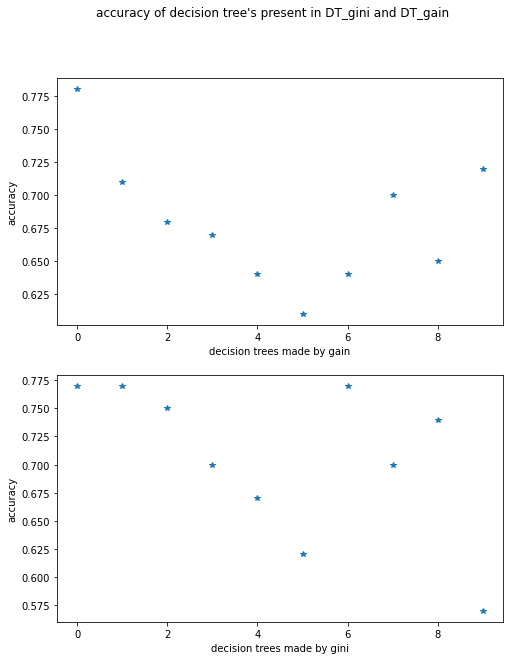

In [220]:
L = [0,1,2,3,4,5,6,7,8,9]
fig, a = plt.subplots(2)
fig.suptitle("accuracy of decision tree's present in DT_gini and DT_gain")
fig.set_figwidth(8)
fig.set_figheight(10)

a[0].plot(L,gain_accuracy,'*')
a[0].set_xlabel("decision trees made by gain")
a[0].set_ylabel("accuracy")

a[1].plot(L,gini_accuracy,'*')
a[1].set_xlabel("decision trees made by gini")
a[1].set_ylabel("accuracy")

print(L)
print('gain -> ',gain_accuracy)
print('gini -> ',gini_accuracy)

In [221]:
print("average accuracy by gain impurity -> ",round(sum(gain_accuracy)/len(gain_accuracy),2))
print("average accuracy by gini impurity -> ",round(sum(gini_accuracy)/len(gini_accuracy),2))

average accuracy by gain impurity ->  0.68
average accuracy by gini impurity ->  0.71


In [161]:
""" 
best possible tree is made by gini impurity 
1st tree of list DT_gini is the best
from the above graph
"""
L = [0,1,2,3,4,5,6,7,8,9]
index = 0
acc = 0
MEt = 'gini'
for i in L:
  if acc < gini_accuracy[i]:
    MEt = 'gini'
    acc = gini_accuracy[i]
    index = i
for i in L:
  if acc < gain_accuracy[i]:
    MEt = 'gain'
    acc = gain_accuracy[i]
    index = i
  
gain_accuracy = []
Depth_tree = []
epochs = 20
for i in range(20):
  Depth_tree.append(DTCla())
lis = []
for i in tqdm_notebook(range(epochs),total=epochs, unit="epoch"):
  if i > 2:
    Depth_tree[i].DecisionTree(X_TRAIN[index], Y_TRAIN[index], Depth = True ,Depth_limit = i, method = MEt)
    lis.append(i)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?epoch/s]

In [222]:
accuracy_depth = []
for i in lis:
  accuracy_depth.append(round(Depth_tree[i].Accuracy(X_TEST[index], Y_TEST[index]),2))

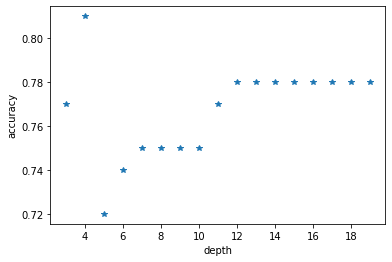

Accuracy ->  [0.77, 0.81, 0.72, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78]
depth ->  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [223]:
plt.plot(lis, accuracy_depth, '*')
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.show()
print("Accuracy -> ",accuracy_depth)
print("depth -> ",lis)

In [164]:
def num_nodes(Tre, ):
  if Tre == None:
    return 0
  return 1 + num_nodes(Tre.left)+num_nodes(Tre.right)


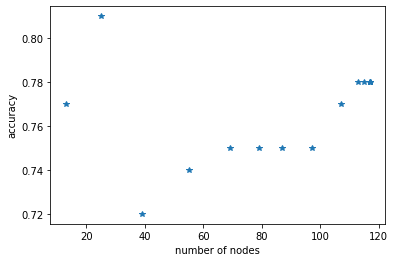

Number of nodes ->  [13, 25, 39, 55, 69, 79, 87, 97, 107, 113, 115, 117, 117, 117, 117, 117, 117]
accuracy ->  [0.77, 0.81, 0.72, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78]


In [225]:
num_of_nodes = []
for i in lis:
  num = num_nodes(Depth_tree[i].Tree)
  num_of_nodes.append(num)

plt.plot(num_of_nodes,accuracy_depth,'*')
plt.xlabel("number of nodes")
plt.ylabel("accuracy")
plt.show()
print("Number of nodes -> ",num_of_nodes)
print("accuracy -> ",accuracy_depth)


In [166]:
def prune( Ori_T, temp_T, i, index):
  """
  Ori_T -> original tree
  temp_T -> node of a tree 
  i -> index
  index -> index value of a test and train data of the decision tree (we have 10 random test train splits)
  """
  if temp_T == None:
    return
  if temp_T.left == None:
    return
  prune(Ori_T,temp_T.left,i+1, index)
  prune(Ori_T,temp_T.right, i+1, index)
  if i > 3:
    acc1 = Ori_T.Accuracy(X_TEST[index], Y_TEST[index])
    x = deepcopy(Ori_T)
    temporary = deepcopy(temp_T)
    temp_T.left = None
    temp_T.right = None
    acc2 = Ori_T.Accuracy(X_TEST[index], Y_TEST[index])
    if acc2 < acc1:
      temp_T.left = temporary.left
      temp_T.right  = temporary.right
  



In [211]:
def print_tree(T,s):
  if T == None:
    return
  S = str(T.name) + ' <= '
  if T.data != None:
    S += str(round(T.data,2)) + ' \n' 
  else:
    S += str(T.data) + '\n'
  if T.gini != None:
    S += 'gini = ' + str(round(T.gini,2)) + ' \n'
  else:
    S += 'gini = ' + str(T.gini) + '\n'
  if T.gain != None:
    S += 'gain = ' + str(round(T.gain,2)) + ' \n'
  else:
    S += 'gain = ' + str(T.gain)+'\n'
  S += 'class = ' + str(T.res)
  # print(S)
  dot.node(str(s),S)
  if s != 0:
    dot.edge(str(int((s-1)/2)),str(s))
  print_tree(T.left,2*s+1)
  print_tree(T.right,2*s+2)

In [212]:
pruning_Tree = deepcopy(DT_gain[index])
prune(pruning_Tree,pruning_Tree.Tree,0,0)

In [213]:
dot = graphviz.Digraph(comment='Pruned_Tree')
dot
print_tree(pruning_Tree.Tree,0)
s1 = 'tree_pruned'
s1 += str(index)
dot.render(s1, view=True)

'tree_pruned0.pdf'

In [214]:
dot = graphviz.Digraph(comment='Pruned_Tree')
dot
print_tree(DT_gain[index].Tree,0)
s1 = 'Treebygain'
s1 += str(index)
dot.render(s1, view=True)

'Treebygain0.pdf'

In [215]:
print(DT_gain[index].Accuracy(X_TEST[index],Y_TEST[index]), pruning_Tree.Accuracy(X_TEST[index],Y_TEST[index]))

0.782608695652174 0.855072463768116


In [216]:
dot = graphviz.Digraph(comment='Depth_tree')
dot
index_1 = 0
for i in range(len(lis)):
  if accuracy_depth[index_1] < accuracy_depth[i]:
    index_1 = i

print_tree(Depth_tree[lis[index_1]].Tree,0)
s1 = 'Best_depth_tree'
s1 += str(index_1)
dot.render(s1, view=True)

'Best_depth_tree1.pdf'

In [217]:
print(index_1)

1


In [218]:
dot = graphviz.Digraph(comment='GINI')
dot

print_tree(DT_gini[0].Tree,0)
s1 = 'Best_acc_tree_by_gini'
dot.render(s1, view=True)

'Best_acc_tree_by_gini.pdf'